In [4]:
from math import exp 
import numpy as np
from itertools import product
import copy

In [98]:
class Cell:
    def __init__(self,car_num = 0, av_num = 0, length = 0.2 , q_max = 1600, f_speed = 40, dt = 10, jam_density = 240, av_lane = False,scale_down = 1):
        """
        f_speed: km/h; length: km; jam_density: veh/km; q_max = veh/h
        """
        self.car_num = car_num; self.av_num = av_num
        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num

        self.length = length; self.f_speed = f_speed; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.dt = dt; self.jam_density = jam_density*(1+0.5*self.av_ratio)
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.av_lane = av_lane; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.demand = 0; self.supply = 0; self.density = self.car_num/self.length
        self.scale_down = scale_down; self.left_flow = 0
        self.right_flow = 0; self.down_flow = 0
        self.left_prob = 0; self.right_prob = 0
        self.down_prob = 0; self.left_in = 0
        self.right_in = 0; self.up_in = 0
        self.exp_right_flow = 0 # 拟向右换道车辆数
        self.exp_left_flow = 0 # 拟向左换道车辆数
        self.exp_down_flow = 0 # 拟向下游的车辆数

    def update_variable(self,left_num=200,right_num=300,down_num=200):
        """
        :param left_num: 左侧元胞车辆数
        :param right_num: 右侧元胞车辆数
        :param down_num: 下游元胞车辆数
        :return: 
        """
        beta1 = -0.4; beta2 = 5; beta3 = -0.1; beta4 = 1
        self.density = self.car_num/self.length
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 # 这个改动较大
        self.demand = max(0, min(self.q_max,self.wave_speed*(self.jam_density-self.density)))*self.dt/3600

    
        left_utility = beta1*(self.car_num-left_num)+beta2
        right_utility = beta1*(self.car_num-right_num) + beta2  
        down_utility = beta3*(self.car_num-down_num)  + beta4 - 0.4*max(0,16-down_num)

        self.left_prob = exp(-left_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.right_prob = exp(-right_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.down_prob =  exp(-down_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        # print(self.down_prob)
        self.exp_down_flow = self.down_prob*self.supply
        self.exp_right_flow = self.right_prob*self.supply # 本车道拟向右换道车辆数
        self.exp_left_flow = self.left_prob*self.supply # 本车道拟向右换道车辆数
        
        if self.av_lane:
            self.right_prob = 1-self.av_ratio
            self.down_prob = self.av_ratio


    def update_car_num(self,up_out,down_demand,left_lane_up_out,left_lane_demand,right_lane_up_out,right_lane_demand,right_lane_exp_left_flow,left_lane_exp_right_flow,right_two_lane_exp_left_flow,left_two_lane_exp_right_flow,up_av_ratio, left_av_ratio, right_av_ratio):
        """
        Args:
            right_av_ratio: 
            up_out: 上游元胞想要出来的车辆数
            down_demand: 下游元胞的需求
            left_lane_up_out: 左侧上游想要直行的车辆数
            left_lane_demand: 左侧元胞供给
            right_lane_up_out: 右侧上游想要直行的车辆数
            right_lane_demand: 右侧元胞供给
            right_lane_exp_left_flow: 右侧想要变道的车辆数
            left_lane_exp_right_flow: 左侧想要变道的车辆数
            right_two_lane_exp_left_flow: 右侧第二个车道往右侧车道换道的车辆数
            left_two_lane_exp_right_flow: 左侧第二个车道往左侧车道换道的车辆数
            up_av_ratio: 
            left_av_ratio: 

        Returns:
        """
        # 三个cell进来的车辆数 上游cell 左侧车道的cell 右侧车道的cell
        self.up_in = min(self.demand,up_out) # 当前车道上游元胞向下走的车辆数
        if right_lane_exp_left_flow+left_lane_exp_right_flow>0:          
            self.right_in = min(right_lane_exp_left_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), right_lane_exp_left_flow)
            self.left_in = min(left_lane_exp_right_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), left_lane_exp_right_flow)
        else:
            self.right_in = 0; self.left_in = 0
       # 需要根据有多少车换道、直行到当前cell来确定换道对supply的影响；目的：体现出换道多交通的负效用
        if self.right_in+self.left_in+self.up_in>0:
            lc_ratio = (self.right_in+ self.left_in)/(self.right_in+self.left_in+self.up_in)
        else:
            lc_ratio = 0
        self.demand = self.demand * (1-lc_ratio*0.2) # 举例子
      # --------------------------------------------------------------------
        
        
        right_up_in = min(right_lane_demand, right_lane_up_out) # 右侧车道元胞直行车辆数
        left_up_in = min(left_lane_demand, left_lane_up_out) # 左侧车道元胞直行车辆数

        # 本cell朝三个方向出去的车辆数
        self.down_flow = min(down_demand,self.down_prob*self.car_num)
        if self.exp_right_flow+right_two_lane_exp_left_flow >0:
            self.right_flow = min(self.exp_right_flow/(self.exp_right_flow+right_two_lane_exp_left_flow)*(right_lane_demand-right_up_in) , self.exp_right_flow)
        else:
            self.right_flow = 0
        
        if self.exp_left_flow+left_two_lane_exp_right_flow > 0:
            self.left_flow = min(self.exp_left_flow/(self.exp_left_flow+left_two_lane_exp_right_flow)*(left_lane_demand-left_up_in) , self.exp_left_flow)
        else:
            self.left_flow = 0
            
    
    
    # 更新该元胞内部车辆数
        self.car_num = self.car_num + self.up_in + self.right_in + self.left_in - self.right_flow - self.down_flow - self.right_flow
        if not self.av_lane:
            self.av_num = (self.car_num-self.right_flow-self.down_flow-self.right_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in*right_av_ratio + self.left_in*left_av_ratio 
        else:
            self.av_num = (self.car_num-self.down_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in

        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num
            
        
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.q_max = self.q_max*(1+0.5*self.av_ratio)
        # print(self.car_num)

class source:
    def __init__(self,car_num=30,q_max=1600,f_speed = 40,length = 0.2,dt = 10):
            self.car_num = car_num
            self.length = length
            self.q_max = q_max
            self.f_speed = f_speed
            self.density = self.car_num/self.length
            self.dt = dt
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
    def variable_update(self,input_flow,down_demand):
            self.car_num = self.car_num + input_flow - min(self.supply, down_demand)
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600

class sink:
    def __init__(self):
        self.car_num = 0
        self.demand = 100000000000


In [217]:
class Agent():
    def __init__(self,lane_num, cell_num, ini_num, ini_action, sim_time_step,sys_time):
        """
        :param lane_num: 研究的范围内多少条道路
        :param cell_num: 研究范围内没条道路多少个cell
        :param initial_num: 每一个cell一开始多少车辆数，比如我们仿真8:00-8:30，或者仿真8:30-9:00这个值不一样
        :param initial_action: 这个是说的哪些segement是av dedicated lane
        :param simulation_time: 仿真多少个时间步
        """
        self.lane_num = lane_num
        self.cell_num = cell_num
        self.ini_num = ini_num
        self.ini_action = ini_action
        self.sim_time_step = sim_time_step
        self.state1 = 0 # 这些状态自己定义哈
        self.state2 = 0
        self.state3 = 0
        self.reward = 0 # reward自己定义
        self.done = False # 是否结束
        self.sys_time = sys_time
        self.num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_ratio_record  = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])

    def run(self):
        global j, i
        Road = [[[] for j in range(self.cell_num)] for i in range(self.lane_num)]
        for i,j in product(range(self.lane_num),range(self.cell_num-2)):
            Road[i][j+1] = Cell(car_num = ini_num[i][j],av_lane=self.ini_action[i][j])
        for i in range(self.lane_num):
            Road[i][0] = source(car_num=0)
            Road[i][-1] = sink()

        input = np.zeros(self.lane_num)

        for t in range(self.sim_time_step):
            Road_copy = Road

            for _ in range(3):
                if Road_copy[i][1].car_num <= 25:
                    input[_] = np.random.poisson(25)
                elif Road_copy[i][1].car_num <= 35:
                    input[_] = np.random.poisson(35)
                elif Road_copy[i][1].car_num <= 45:
                    input[_] = np.random.poisson(45)

            self.num_record[i][j][t] = Road[i][j].car_num
            for i in range(self.lane_num):
                for j in range(self.cell_num):
                    if j == 0:
                            Road[i][j].variable_update(input_flow = input[i],down_demand = Road[i][j+1].demand)
                    elif j >= self.cell_num-1:
                        pass
                    else:
                            if i == 0:
                                Road[i][j].update_variable(left_num = 10000,
                                                           right_num = Road_copy[i+1][j].car_num,
                                                           down_num = Road_copy[i][j+1].car_num)
                                if j == 1:#range(1,cell_num-1) 当j=1时，指向source，source只有supply
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].supply,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = 0,
                                                              left_lane_demand = 0,
                                                              right_lane_up_out = Road_copy[i+1][j-1].supply,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = 0,
                                                              right_two_lane_exp_left_flow = Road_copy[i+2][j].exp_left_flow,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = 0,
                                                              left_av_ratio = 0,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                                else:
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = 0,
                                                              left_lane_demand = 0,
                                                              right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = 0,
                                                              right_two_lane_exp_left_flow = Road_copy[i+2][j].exp_left_flow,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = 0,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                                self.num_record[i][j][t] = Road[i][j].car_num
                            if i == 1:
                                Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,
                                                           right_num = Road_copy[i+1][j].car_num,
                                                           down_num = Road_copy[i][j+1].car_num)
                                if j == 1:
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].supply,
                                                          down_demand = Road_copy[i][j+1].demand,
                                                          left_lane_up_out = Road_copy[i-1][j-1].supply,
                                                          left_lane_demand = Road_copy[i-1][j].demand,
                                                          right_lane_up_out = Road_copy[i+1][j-1].supply,
                                                          right_lane_demand = Road_copy[i+1][j].demand,
                                                          right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                          left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                          right_two_lane_exp_left_flow = 0,
                                                          left_two_lane_exp_right_flow = 0,
                                                          up_av_ratio = 0,
                                                          left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                          right_av_ratio = Road_copy[i+1][j].av_ratio)
                                else:
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                                self.num_record[i][j][t] = Road[i][j].car_num
                            if i == 2:
                                Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,
                                                           right_num = 10000,
                                                           down_num = Road_copy[i][j+1].car_num)
                                if j == 1:
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].supply,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].supply,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = 0,
                                                              right_lane_demand = 0,
                                                              right_lane_exp_left_flow = 0,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = Road_copy[i-2][j].exp_right_flow,
                                                              up_av_ratio = 0,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = 0)
                                else:
                                    Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = 0,
                                                              right_lane_demand = 0,
                                                              right_lane_exp_left_flow = 0,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = Road_copy[i-2][j].exp_right_flow,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = 0)
                                self.num_record[i][j][t] = Road[i][j].car_num
                            
                            
                             

In [218]:
ini_num = np.random.randint(5,40 , size=(3, 100))
ini_action = np.zeros([3,100])

In [219]:
ini_num

array([[33,  6, 30, 37, 27, 32, 12, 36, 27, 36, 32, 14, 27,  6, 35, 33,
        23, 39, 13, 15, 25, 10,  5, 36, 30, 35, 28, 29, 30, 12, 34, 15,
        11,  6, 29, 17, 10, 24,  7, 13, 33, 33, 38, 18, 39, 32, 20, 14,
        21, 26, 26, 33, 18, 19, 31, 16, 21, 24, 11, 36, 12,  5, 39, 17,
        26, 37, 16, 30, 25, 24, 38, 34, 33, 17, 36, 35, 25, 31, 11, 38,
        34,  5, 39, 28, 31,  5,  5, 28, 12, 13, 21, 25, 30, 19, 11, 23,
        36, 23, 37, 38],
       [16, 20, 13,  8, 32,  6, 38, 14,  6, 18, 30, 35, 34, 28, 28, 12,
        24, 30,  6, 33, 16, 38, 38, 33, 31, 31, 16, 34, 22, 27, 25, 30,
        16, 39, 35, 31, 19, 22, 15, 32, 30, 34, 31, 31, 20, 38, 23, 33,
        14, 17, 18, 37, 37, 31, 18, 36, 39,  8, 28, 36, 11, 17,  7, 16,
        20, 21, 10, 15, 12, 17, 22, 26, 12, 35, 34, 27, 18, 28, 31, 28,
        31, 30, 26, 11, 14, 37, 22, 24, 25, 29, 25, 23, 35, 21, 12, 27,
        17, 34, 24,  9],
       [16, 20,  5, 24, 33, 22, 19, 12, 28, 31, 34,  5, 32, 33, 34, 35,
        12, 10

In [220]:
agent = Agent(3,100,ini_num,ini_action,100,0)

In [221]:
agent.run()

In [222]:
import matplotlib.pyplot as plt 

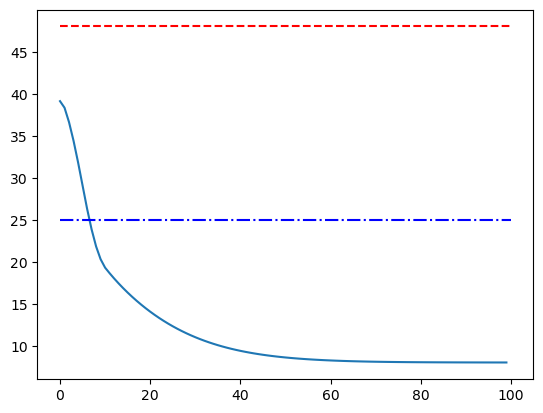

In [226]:
plt.plot(agent.num_record[2][0:99][95])
plt.hlines(48,0,100,color='red',ls = '--')
plt.hlines(25,0,100,color='blue',ls='-.')

In [66]:
200/(1000/240)

48.0

In [343]:
supply = []
demand = []
q = int(1600*1.5)
jam = int(240*1.5)
w = q/(jam-q/40)
for i in range(0,jam):
    k = i 
    supply.append(min(q,40*k))
    demand.append(min(q,w*(jam-k)))
# supply =max(0, min(self.q_max,1000*self.density * self.f_speed * self.dt / 3600)* self.length/1000)
#     self.demand =max(0, min(self.q_max,1000*(self.jam_density - self.density) * self.wave_speed * self.dt / 3600) * self.length/1000)


# self.q_max/(self.jam_density-self.q_max/self.f_speed)


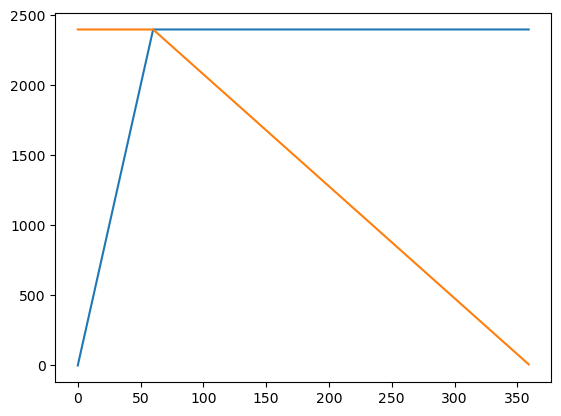

In [344]:
plt.plot(supply)

plt.plot(demand)

In [85]:
class source:
    def __init__(self,car_num,q_max=1600,f_speed = 40,length = 0.2,dt = 10):
        self.car_num = car_num
        self.length = length
        self.q_max = q_max
        self.f_speed = f_speed
        self.density = self.car_num/self.length
        self.dt = dt 
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 
    def variable_update(self,input_flow,down_demand):
            self.car_num = self.car_num + input_flow - min(self.supply, down_demand)
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600


class sink:
    def __init__(self):
        self.car_num = 0
        self.demand = 100000000000
        
        